# The Constitutional Controller: Doubt-Calibrated Steering of Compliant Agents

## Setup

In [3]:
import glob
import json
from copy import deepcopy
from pathlib import Path
from pickle import dump

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.patches import Polygon
from networkx import Graph
from numpy import array, eye, float32
from PIL import Image

from promis import ConstitutionalController, ProMis, StaRMap
from promis.coco import DoubtDensity
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianPolygon,
    CartesianRasterBand,
    PolarLocation,
)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Make plots look nice in a paper
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sns.set_theme(style="ticks", rc={"legend.title_fontsize": 15})  # "figure.figsize": (10, 4)
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

## Preparing the scenario

Loading the image, loading the identified foam blocks from the vision model, and rescaling everything to a common reference in millimeters.

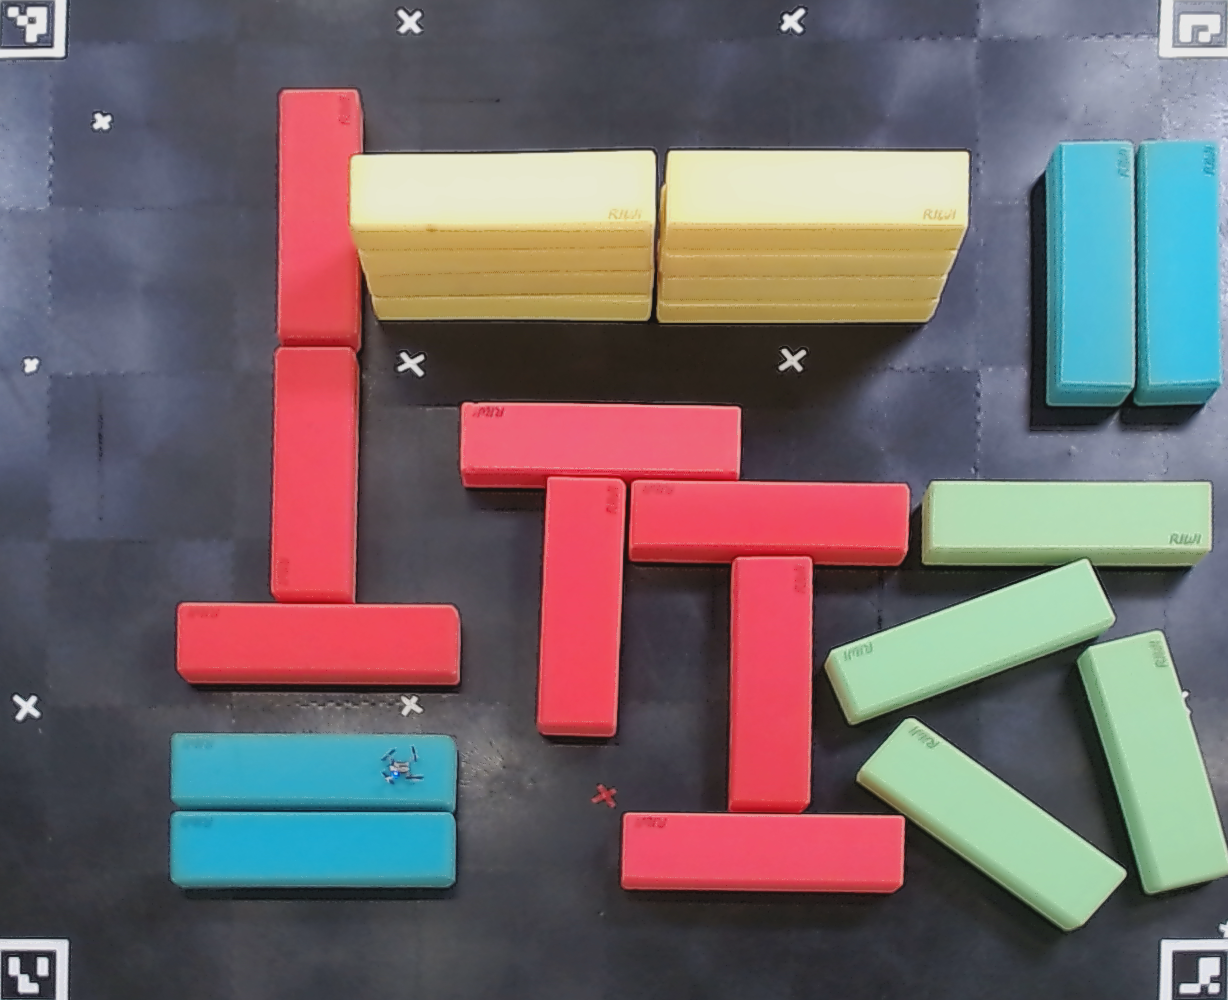

In [6]:
scene_image = Image.open("coco_linearized_image.png")
scene_image

In [7]:
boxes_df = pd.read_csv("coco_bounding_boxes.csv")
boxes_df

x      y  width  height   area  stability_score     avg_hue   color  \
0    857.0  718.0  268.0   213.0  23442         0.987449   60.639493   green   
1    270.0  347.0   88.0   256.0  21633         0.983448  169.852494     red   
2    921.0  481.0  291.0    86.0  24434         0.991605   55.644512   green   
3    824.0  560.0  290.0   165.0  22460         0.986512   63.096527   green   
4    176.0  603.0  283.0    83.0  22956         0.984746  156.305280     red   
5   1078.0  631.0  149.0   263.0  23535         0.984483   62.889356   green   
6    275.0   89.0   87.0   511.0  20281         0.984647  157.864947     red   
7    277.0   89.0   85.0   261.0  20277         0.985652  157.793017     red   
8    459.0  403.0  281.0    85.0  21677         0.986254  168.381510     red   
9    537.0  477.0   89.0   260.0  20830         0.985040  168.560922     red   
10   921.0  481.0  291.0   161.0  24423         0.991484   55.591369   green   
11   841.0  481.0  371.0   225.0  24475         0.984727   55.596200   green   
12   621.0  813.0  283.0    79.0  21752         0.985215  168.387643     red   
13   857.0  607.0  269.0   324.0  23496         0.979946   60.623808   green   
14  1133.0  140.0   88.0   266.0  21732         0.972221   95.388551    blue   
15  1045.0  141.0   90.0   266.0  23529         0.983601   95.043138    blue   
16   628.0  481.0  281.0    85.0  22264         0.980378  156.182357     red   
17   170.0  811.0  285.0    77.0  21810         0.979635   95.452361    blue   
18   656.0  150.0  313.0   173.0  51288         0.985704   24.693944  yellow   
19   728.0  556.0   84.0   257.0  20919         0.980561  171.159711     red   
20   171.0  734.0  286.0    78.0  21824         0.984939   95.286199    blue   
21   170.0  733.0  287.0   151.0  21646         0.970442   95.186963    blue   
22   728.0  502.0  177.0   311.0  20929         0.977016  171.136222     red   
23   350.0  151.0  305.0   170.0  49467         0.986318   24.566297  yellow   
24   176.0  564.0  284.0   121.0  23007         0.974139  156.675620     red   

                                        poly_oriented  
0   [(1129, 871), (1072, 938), (850, 778), (909, 7...  
1    [(361, 347), (354, 603), (269, 603), (274, 347)]  
2   [(1212, 482), (1212, 567), (920, 565), (922, 4...  
3   [(1120, 628), (846, 728), (818, 653), (1087, 5...  
4    [(459, 604), (459, 686), (176, 684), (176, 602)]  
5   [(1236, 874), (1144, 895), (1072, 649), (1165,...  
6      [(359, 350), (276, 344), (278, 90), (362, 88)]  
7      [(359, 350), (276, 344), (278, 90), (362, 88)]  
8    [(740, 405), (740, 478), (458, 491), (460, 401)]  
9    [(626, 478), (615, 738), (535, 734), (545, 476)]  
10  [(1212, 482), (1212, 567), (920, 565), (922, 4...  
11  [(1212, 482), (1212, 567), (921, 565), (921, 4...  
12   [(904, 815), (902, 893), (621, 889), (621, 812)]  
13  [(1130, 871), (1072, 938), (850, 778), (908, 7...  
14  [(1217, 140), (1222, 403), (1132, 406), (1137,...  
15  [(1135, 407), (1045, 407), (1045, 142), (1135,...  
16   [(909, 484), (906, 566), (626, 562), (630, 478)]  
17   [(455, 812), (455, 888), (170, 888), (170, 810)]  
18   [(997, 150), (930, 321), (655, 323), (659, 150)]  
19   [(810, 813), (727, 811), (730, 557), (812, 554)]  
20   [(458, 734), (455, 812), (171, 809), (171, 734)]  
21   [(457, 734), (455, 812), (169, 809), (171, 732)]  
22   [(812, 557), (810, 813), (727, 811), (730, 557)]  
23   [(655, 321), (376, 318), (328, 154), (655, 150)]  
24   [(461, 604), (458, 685), (176, 683), (176, 602)]

In [8]:
# Calculate the size of the image in millimeters
average_box_width_pixels = (277 + 281 + 245) / 3
average_box_height_pixels = (65 + 65 + 74) / 3

# True measurements in mm
box_width_mm = 800
box_height_mm = 200

# Calculate the pixel size in mm
pixel_height_mm = box_height_mm / average_box_height_pixels
pixel_width_mm = box_width_mm / average_box_width_pixels

# The image is linearized, so these two should not be too different (at most 5%)
assert abs(pixel_height_mm - pixel_width_mm) / pixel_height_mm < 0.05

# Size of the entire setup
field_width_mm = scene_image.width * pixel_width_mm
field_height_mm = scene_image.height * pixel_height_mm

(field_width_mm, field_height_mm), (pixel_height_mm, pixel_width_mm)

((3670.236612702366, 2941.1764705882356),
 (2.9411764705882355, 2.9887920298879203))

In [9]:
# Check that the aspect ratios are not too far off
(scene_image.width / scene_image.height), (field_width_mm / field_height_mm)

(1.228, 1.2478804483188044)

In [10]:
map_features = []
for index, box in boxes_df.iterrows():
    coords = array(
        json.loads(box["poly_oriented"].replace("(", "[").replace(")", "]")), dtype=float32
    )
    if coords.shape[0] != 4:
        print(f"The coordinates at index #{index} are not in the right format, skipping")
        continue

    # Rescale the coordinates from pixels to millimeters in the real world
    coords[:, 0] *= pixel_width_mm
    coords[:, 1] *= pixel_height_mm

    # Make sure that (0, 0) is the center of the cage
    coords[:, 0] -= field_width_mm / 2
    coords[:, 1] -= field_height_mm / 2
    coords[:, 1] *= -1  # Flip the y-axis to go from image to real world coordinates

    # Convert the coordinates to a CartesianPolygon
    map_features.append(CartesianPolygon.from_numpy(coords.T, location_type=box["color"]))

len(map_features), map_features[0]

(25,
 CartesianPolygon(locations=[(1539.2279052734375, -1091.1763916015625), (1368.8665771484375, -1288.2352294921875), (705.3548583984375, -817.6470947265625), (881.6934814453125, -626.4705810546875), (1539.2279052734375, -1091.1763916015625)], location_type=green, identifier=169775070840615221))

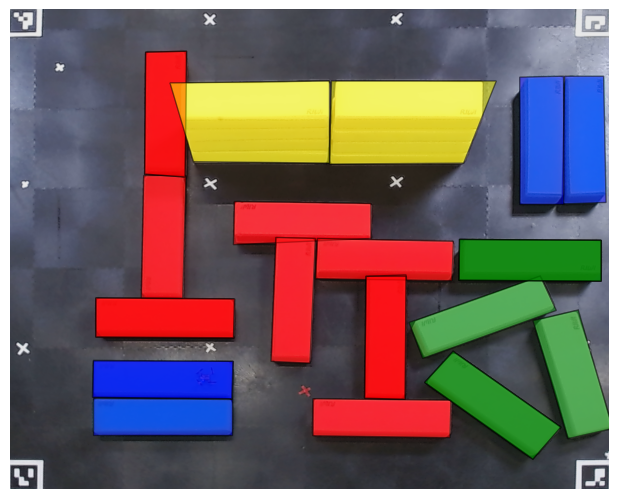

In [11]:
# Visualize the bounding boxes
plt.imshow(
    scene_image,
    extent=(-field_width_mm / 2, field_width_mm / 2, -field_height_mm / 2, field_height_mm / 2),
)
for polygon in map_features:
    plt.gca().add_patch(
        Polygon(
            [(loc.x, loc.y) for loc in polygon.locations],
            fill=True,
            edgecolor="black",
            facecolor=polygon.location_type,
            linewidth=1,
            alpha=0.5,
        )
    )

plt.gca().set_xticks([])
plt.gca().set_yticks([])
sns.despine(bottom=True, left=True)
plt.tight_layout(pad=0)

plt.savefig("coco_linearized_image_with_bounding_boxes.pdf", bbox_inches="tight")
plt.show()

## Learn the doubt model

In [12]:
# Select a compute device
devices = ["cpu", "mps", "cuda"]
device = devices[2]
# torch.set_default_device(device)
torch.set_default_dtype(torch.double)

In [53]:
# Data preparation
timescales_float = [1.2, 1.5, 2.0, 3.0, 6.0]
timescales = ["1_2", "1_5", "2", "3", "6"]
timescale_str_to_speed = {"1": 1.2, "1_2": 1.0, "1_5": 0.8, "2": 0.6, "3": 0.4, "6": 0.2}
tunings = [
    "Default Tuning (T_PID = 0)",
    "Altered Position Tuning (T_PID = 1)",
    "Altered Att and Att Rate Tuning (T_PID = 2)",
]

speed_to_timescale = {1.2: 1.0, 1.0: 1.2, 0.8: 1.5, 0.6: 2.0, 0.4: 3.0, 0.2: 6.0}
timescale_to_speed = {1.0: 1.2, 1.2: 1.0, 1.5: 0.8, 2.0: 0.6, 3.0: 0.4, 6.0: 0.2}
trained_speeds = [timescale_to_speed[ts] for ts in timescales_float]

training_xy = None
training_controller = None
training_speed = None

for controller_index, tuning in enumerate(tunings):
    for time_index, timescale in enumerate(timescales):
        path = f"data/drone-doubt-recordings/{tuning}_timescale{timescale}"

        matching_files = glob.glob(f"{path}*.csv")

        dfs = []
        for match in matching_files:
            dfs.append(pd.read_csv(match))

        for df in dfs:
            # xs = torch.from_numpy(np.abs(df['stateEstimateX'] - df['posCtltargetX']).to_numpy())[:, None]
            # ys = torch.from_numpy(np.abs(df['stateEstimateY'] - df['posCtltargetY']).to_numpy())[:, None]
            xs = torch.from_numpy(df["errorX"].to_numpy())[:, None]
            ys = torch.from_numpy(df["errorY"].to_numpy())[:, None]
            xy = torch.hstack([xs, ys])
            controller = torch.tensor([controller_index] * len(xs))[:, None]

            time_scale = timescales_float[time_index]
            speed = torch.tensor([timescale_to_speed[time_scale]] * len(xs))[:, None]

            if training_xy is None:
                training_xy = xy
                training_controller = controller
                training_speed = speed
            else:
                training_xy = torch.vstack([training_xy, xy])
                training_controller = torch.vstack([training_controller, controller])
                training_speed = torch.vstack([training_speed, speed])

            # Add randomly rotated copies
            for _ in range(4):
                theta = torch.rand(1).item() * 2 * np.pi  # angle between 0 and 2π

                rotation_matrix = torch.tensor(
                    [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
                )

                training_xy = torch.vstack([training_xy, xy @ rotation_matrix.T])
                training_controller = torch.vstack([training_controller, controller])
                training_speed = torch.vstack([training_speed, speed])

In [54]:
# Training
doubt_space = {
    "controller": {
        "type": "categorical",
        "number_of_classes": 3,
        "values": training_controller,
    },
    "speed": {
        "type": "continuous",
        "values": training_speed,
    },
}

doubt_density = DoubtDensity(
    doubt_space=doubt_space, number_of_states=2, number_of_hidden_features=100, number_of_layers=5
)

number_of_epochs = 1
batch_size = 100
losses = doubt_density.fit(training_xy, doubt_space, number_of_epochs, batch_size)

Learning Doubt Density: 100%|██████████| 1/1 [00:03<00:00,  3.42s/epoch]


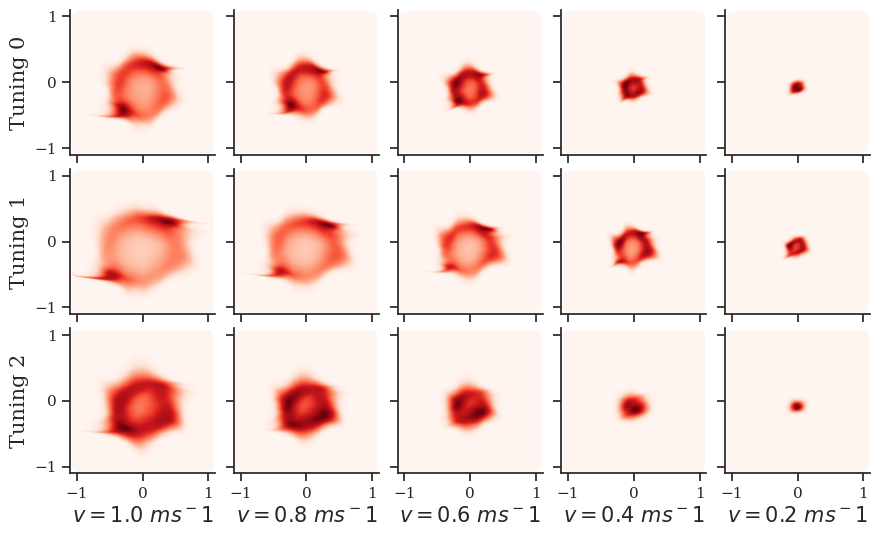

In [55]:
# Visualization
fig, ax = plt.subplots(3, 5, figsize=(9, 5.5), sharex=True, sharey=True)
for time_index, speed in enumerate(trained_speeds):
    ax[2, time_index].set_xlabel(rf"$v = {speed}\ ms^{-1}$", fontsize=15)

for controller_index, tuning in enumerate(tunings):
    for time_index, speed in enumerate(trained_speeds):
        axis = ax[controller_index, time_index]
        axis.set_aspect(1)
        axis.set_yticks([-1, 0, 1])
        axis.set_xticks([-1, 0, 1])

        if time_index == 0:
            axis.set_ylabel(f"Tuning {controller_index}", fontsize=15)

        resolution = 250
        xline = torch.linspace(-1.0, 1.0, resolution)
        yline = torch.linspace(-1.0, 1.0, resolution)
        xgrid, ygrid = torch.meshgrid(xline, yline, indexing="xy")
        states = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            doubt_space["speed"]["values"] = torch.tensor([speed] * resolution * resolution)[
                :, None
            ]
            doubt_space["controller"]["values"] = torch.tensor(
                [controller_index] * resolution * resolution
            )[:, None]
            density = doubt_density.prob(states, doubt_space).reshape(resolution, resolution)

        axis.scatter(xgrid.numpy(), ygrid.numpy(), c=density.numpy(), cmap="Reds", rasterized=True)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(
    wspace=0.1,
    hspace=0.1,
)
plt.savefig("doubt_density.pdf")
plt.show()

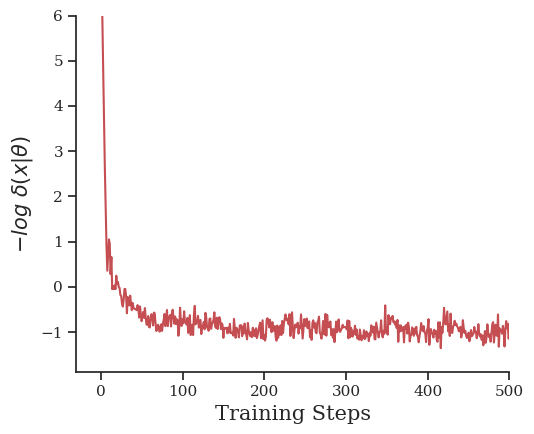

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
ax.plot(range(len(losses)), losses, c='r')
# ax.set_aspect(len(losses) / 12)
ax.set_xlim(None, 500)
ax.set_ylim(None, 6)
ax.set_ylabel(r"$-log\ \delta(x | \theta)$", fontsize=15)
ax.set_xlabel("Training Steps", fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig('doubt_loss.pdf', bbox_inches=0)
plt.show()

## Model the environment using StaRMap / ProMis

In [13]:
# Covariance matrices for some of the features
# Used to draw random translations representing uncertainty for the respective features
pos_std = 50  # millimeters
covariance = {
    "red": pos_std**2 * eye(2),
    "green": pos_std**2 * eye(2),
    "blue": pos_std**2 * eye(2),
    "yellow": pos_std**2 * eye(2),
}


# The probabilistic, logical constraints to fulfill during a mission
def logic(speed: float) -> str:
    return rf"""
    % Perception from sensors
    velocity ~ normal({speed}, 0.1).

    % Background knowledge
    rule_1(X) :- \+ over(X, red).
    rule_2(X) :- distance(X, yellow) > 50.
    rule_3(X) :- \+ over(X, green); velocity < 0.8.

    % Compliance with Constitution P(C | x, z)
    landscape(X) :- rule_1(X), rule_2(X), rule_3(X).
    """

# The mission area, points that will be estimated from 25 samples and points that will be interpolated
origin = PolarLocation(latitude=0.0, longitude=0.0)  # Irrelevant for Cartesian maps
number_of_random_maps = 25
support = CartesianRasterBand(
    origin, (300, 300), field_width_mm, field_height_mm
)  # This is the set of points that will be directly computed through sampling (expensive)
target = CartesianRasterBand(
    origin, (300, 300), field_width_mm, field_height_mm
)  # This is the set of points that will be interpolated from the support set (cheap)

uam = CartesianMap(origin, map_features)
uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier

landscape_path = Path("data/virtual_setup_landscape.pkl")
if landscape_path.exists():
    landscape = CartesianCollection.load(landscape_path)

else:
    # Setting up the probabilistic spatial relations from the map data
    star_map = StaRMap(target, uam)
    # This estimates all spatial relations that are relevant to the given logic
    concrete_logic = logic(speed=0.25)
    star_map.initialize(support, number_of_random_maps, concrete_logic)
    star_map.save("data/virtual_setup_star_map.pkl")

    # Solve the mission area with ProMis
    promis = ProMis(star_map)
    landscape = promis.solve(support, concrete_logic, n_jobs=4, batch_size=8, show_progress=True)
    landscape.save(landscape_path)

star_map = StaRMap.load("data/virtual_setup_star_map.pkl")

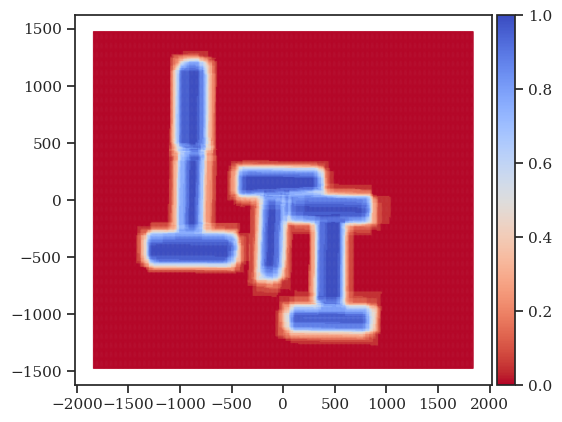

In [14]:
coollection = star_map.get("over", "red").parameters
img = coollection.scatter(
    value_index=0,
    plot_basemap=False,
    rasterized=True,
    cmap="coolwarm_r",
    s=0.25,
)
cbar = plt.colorbar(img, pad=0.01)
plt.show()

In [59]:
# plt.imshow(
#     scene_image.convert("L"),
#     cmap="gray",
#     extent=landscape.extent(),
#     rasterized=True,
# )
# # image = landscape.scatter(
# #     plot_basemap=False,
# #     ax=plt.gca(),
# #     rasterized=True,
# #     cmap="coolwarm_r",
# #     alpha=0.6,
# #     s=0.15,
# #     vmin=0,
# #     vmax=1,
# # )
# image = plt.imshow(
#     landscape.values().reshape(landscape.resolution)[::-1, :],
#     extent=landscape.extent(),
#     cmap="coolwarm_r",
#     alpha=0.6,
#     vmin=0,
#     vmax=1,
#     rasterized=True,
# )
# cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
# cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
# cbar.solids.set(alpha=1)

# # plt.title("P(mission_landscape)")
# # plt.xlabel("x / m")
# # plt.ylabel("y / m")
# # ticks = [-1_500, 0, 1_500]
# # labels = ["-1.5", "0", "1.5"]
# # plt.xticks(ticks, labels)
# # plt.yticks(ticks, labels)
# # plt.xlim([-1_850, 1_850])
# # plt.ylim([-1_500, 1_500])

# plt.gca().set_aspect(scene_image.width / scene_image.height, adjustable="box")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# sns.despine(bottom=True, left=True)

# plt.savefig("drone_landscape_high_speed.pdf", bbox_inches="tight")
# plt.show()

## Adjust the landscape using the doubt & plan paths for experiments

Output()

Lowered zoom level to keep map size reasonable. (z = 14)


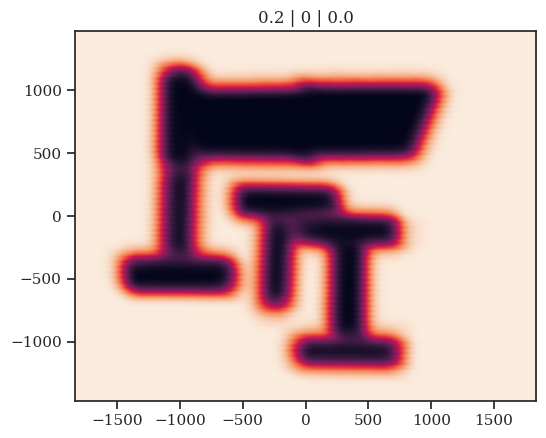

Output()

Lowered zoom level to keep map size reasonable. (z = 14)


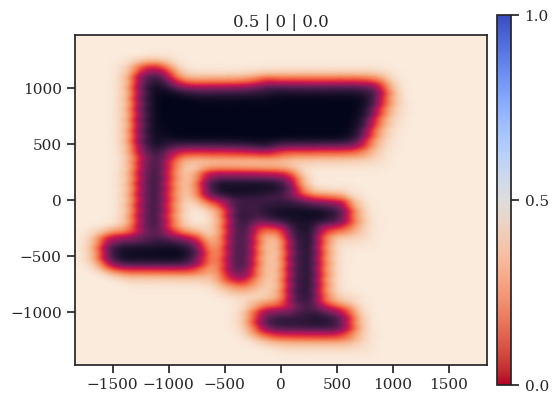

Output()

Lowered zoom level to keep map size reasonable. (z = 14)


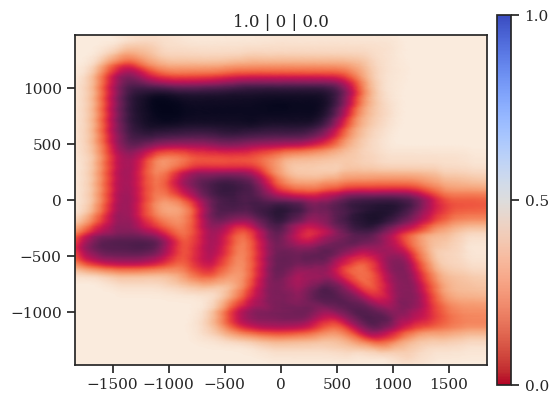

FileNotFoundError: [Errno 2] No such file or directory: 'data/drone-exp/original_path-speed-0.20-yaw-1.57.npy'

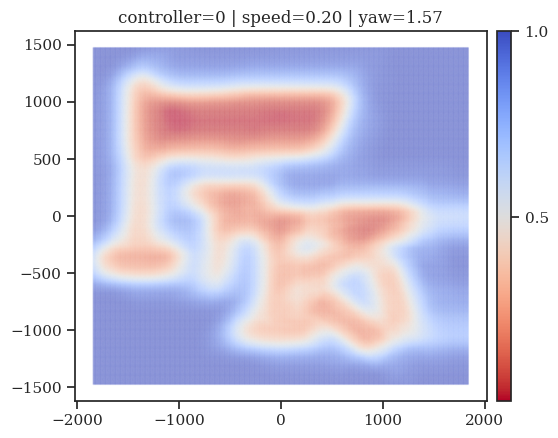

In [18]:
# Load the landscape produced by promis.ipynb and init CoCo
from promis import ConstitutionalController
from pathlib import Path
from networkx import Graph

coco = ConstitutionalController()

Path("data/drone-exp").mkdir(exist_ok=True)

landscapes = {}

# Select different doubt feature values, here we have just one feature velocity
# and use it directly as doubt density parameter
for controller in [0]:
    start = (-600, -900)
    goal = (1_350, 1_000)

    min_speed = 0.3
    max_speed = 1.4

    # speeds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    speeds = [0.2, 0.5, 1.0]
    yaws = [0.0 * np.pi, 0.5 * np.pi, 1.0 * np.pi]
    start_speed = speeds[0]
    end_speed = speeds[0]

    # Only comes from the speed component
    min_cost = min_speed / max_speed  # All speed costs are scaled to this anyway
    vertical_weight = min_cost

    augmented_graphs: list[Graph] = []
    for yaw in yaws:
        for speed in speeds:
            plt.title(f"controller={controller} | speed={speed:.2f} | yaw={yaw:.2f}")

            def cost_model(p):
                consitution_cost = (1.0 - p) * 2.0
                time_cost = min_speed / speed
                return consitution_cost + time_cost

            def value_filter(p):
                return p >= min_cost

            # Compute the landscape
            try:
                landscape = landscapes[speed]
                path_wo_doubt = np.load(f"data/drone-exp/original_path-speed-{speed:.2f}-yaw-{yaw:.2f}.npy")
            except KeyError:
                promis = ProMis(star_map)
                landscape = promis.solve(
                    support, logic(speed=speed), n_jobs=4, batch_size=8, show_progress=True
                )
                landscapes[speed] = landscape

                # Save the landscape for later use
                landscape.save(f"data/drone-exp/original_landscape-speed-{speed:.2f}-yaw-{yaw:.2f}.pkl")

                # Search for a path
                # path_wo_doubt = landscape.search_path(
                #     start, goal, cost_model=cost_model, value_filter=value_filter, min_cost=min_cost
                # )
                # np.save(f"data/drone-exp/original_path-speed-{speed:.2f}-yaw-{yaw:.2f}.npy", path_wo_doubt)

            # Then express doubt
            ds = deepcopy(doubt_space)
            ds["controller"]["values"] = torch.tensor([[controller]])
            ds["speed"]["values"] = torch.tensor([[speed]])
            ds["yaw"]["values"] = torch.tensor([[yaw]])
            augmented_landscape: CartesianRasterBand = coco.apply_doubt(
                landscape=landscape,
                doubt_density=doubt_density,
                doubt_space=ds,
                number_of_samples=100,
            )
            augmented_landscape.save(
                f"data/drone-exp/augmented_landscape-controller-{controller}-speed-{speed:.2f}-yaw-{yaw:.2f}.pkl"
            )

            augmented_landscape.scatter(vmin=0, vmax=1)
            plt.title(f"{speed} | {controller} | {yaw}")        
            plt.show()

            # Turn into a graph and save it
            augmented_graph = augmented_landscape.to_graph(
                cost_model=cost_model, value_filter=value_filter
            )
            with open(
                f"data/drone-exp/augmented_graph-controller-{controller}-speed-{speed:.2f}-yaw-{yaw:.2f}.pkl", "wb"
            ) as f:
                dump(augmented_graph, f)
            augmented_graphs.append(augmented_graph)

            # Plot the landscape
            image = augmented_landscape.scatter(
                s=0.4, plot_basemap=False, rasterized=True, cmap="coolwarm_r", alpha=0.25
            )
            cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
            cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
            cbar.solids.set(alpha=1)

            # # Search for a path
            # path = augmented_landscape.search_path(
            #     start, goal, cost_model=cost_model, value_filter=value_filter, min_cost=min_cost
            # )
            # np.save(
            #     f"data/drone-exp/augmented_path-controller-{controller}-speed-{speed:.2f}-yaw-{yaw:.2f}.npy", path
            # )

            # Plot the path
            # scatter = plt.scatter(
            #     [n[0] for n in path_wo_doubt],
            #     [n[1] for n in path_wo_doubt],
            #     s=1,
            #     c="black",
            #     vmin=0,
            #     vmax=1,
            # )
            # scatter = plt.scatter(
            #     [n[0] for n in path],
            #     [n[1] for n in path],
            #     s=1,
            #     c=[
            #         coco.compliance(
            #             path=path,
            #             landscape=augmented_landscape,
            #             doubt_density=doubt_density,
            #             doubt_space=doubt_space,
            #             number_of_samples=100,
            #         )
            #     ],
            #     vmin=0,
            #     vmax=1,
            #     cmap="berlin",
            # )
            # cbar = plt.colorbar(scatter, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
            # cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
            # cbar.solids.set(alpha=1)

            # plt.gca().set_aspect(scene_image.width / scene_image.height, adjustable="box")
            # plt.gca().set_xticks([])
            # plt.gca().set_yticks([])
            # sns.despine(bottom=True, left=True)

            # plt.show()

    extended_graph = CartesianRasterBand.stack_graphs(
        augmented_graphs, labels=[s for s in speeds], vertical_weight=vertical_weight
    )
    with open(f"data/drone-exp/extended_graph-controller-{controller}.pkl", "wb") as f:
        dump(extended_graph, f)

    path = augmented_landscape.search_path(  # sic
        (*start, start_speed),
        (*goal, end_speed),
        graph=extended_graph,
        cost_model=cost_model,
        value_filter=value_filter,
        min_cost=min_cost,
    )
    np.save(f"data/drone-exp/extended_path-controller-{controller}.npy", path)

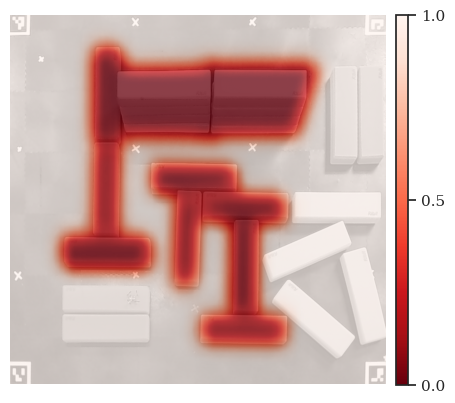

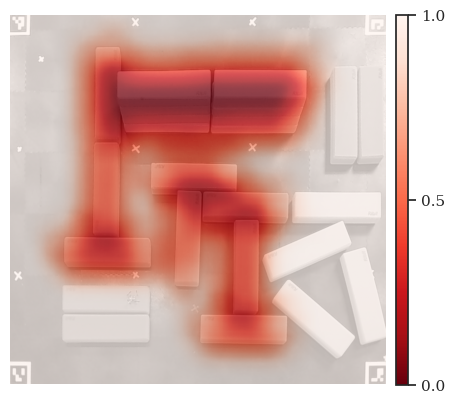

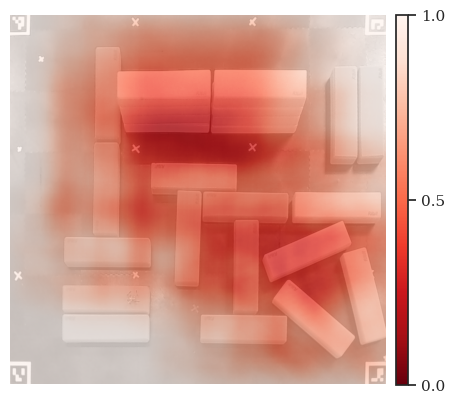

In [ ]:
controllers = [0]
# speeds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# speeds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for controller in controllers:
    for speed in speeds:
        show_landscape = CartesianCollection.load(f"data/drone-exp/augmented_landscape-controller-{controller}-speed-{speed:.2f}.pkl")
        
        plt.imshow(
            scene_image.convert("L"),
            cmap="gray",
            extent=landscape.extent(),
            rasterized=True,
        )

        show_landscape.data['v0'] = show_landscape.data['v0'].clip(0.0, 1.0)
        
        image = plt.imshow(
            show_landscape.values().reshape(show_landscape.resolution)[::-1, :],
            extent=landscape.extent(),
            cmap="Reds_r",
            alpha=0.75,
            vmin=0.0,
            vmax=1.0,
            rasterized=True,
        )
        cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
        cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
        cbar.solids.set(alpha=1)

        plt.gca().set_aspect(scene_image.width / scene_image.height, adjustable="box")
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        sns.despine(bottom=True, left=True)

        plt.savefig(f"augmented_landscape_overlay-controller-{controller}-speed-{speed:.2f}.pdf", bbox_inches="tight")
        plt.show()

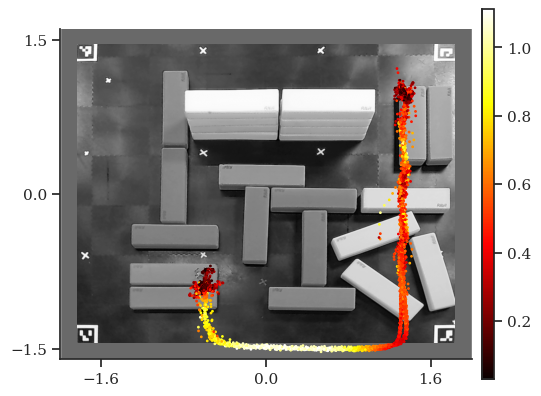

In [ ]:
import glob
import pandas as pd
import seaborn as sns

plt.gca().add_patch(
    plt.Rectangle((-2.0, -1.6), 4.0, 4.0, fc="dimgray", zorder=1)
)

plt.imshow(
    scene_image.convert("L"),
    cmap="gray",
    extent=(-1.835, 1.835, -1.45, 1.45),
    rasterized=True,
    zorder=2
)

plt.xlim(-2, 2)
plt.ylim(-1.6, 1.6)
plt.xticks([-1.6, 0.0, 1.6])
plt.yticks([-1.5, 0.0, 1.5])

matching_files = glob.glob("rosbag-recordings/coco-dynamic/*.csv")
for file in matching_files:
    df = pd.read_csv(file)
    image = plt.scatter(df['stateEstimateX'], df['stateEstimateY'], c=df['velocity'], cmap="hot", s=1, zorder=3)

cbar = plt.colorbar(image, aspect=30, pad=0.02)
cbar.solids.set(alpha=1)

sns.despine()
plt.show()

/var/folders/6d/lnl2js6d6c979vbqkyk58b8w0000gn/T/ipykernel_14640/2628332718.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


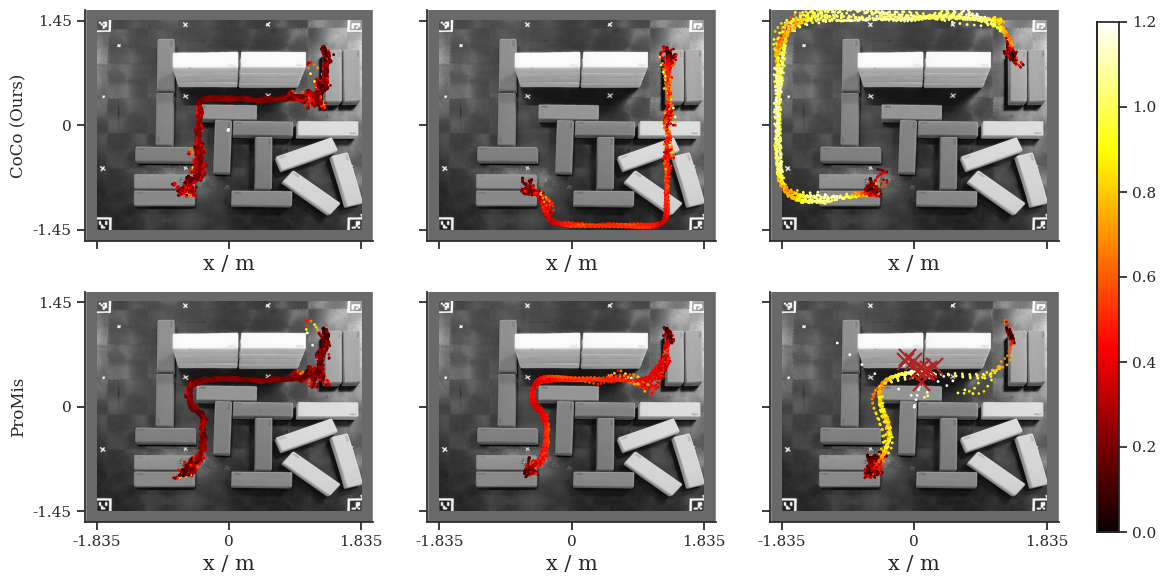

In [8]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)

paths = [
    ["rosbag-recordings/coco-fixed-0.2/*.csv", "rosbag-recordings/coco-fixed-0.5/*.csv", "rosbag-recordings/coco-fixed-1.0/*.csv"],
    ["rosbag-recordings/promis-0.2/*.csv", "rosbag-recordings/promis-0.5/*.csv", "rosbag-recordings/promis-1.0/*.csv"],
]

axes[0,0].set_ylabel("CoCo (Ours)")
axes[1,0].set_ylabel("ProMis")
axes[1,0].set_xlabel(r"$v = 0.2\ ms^{-1}$")
axes[1,1].set_xlabel(r"$v = 0.5\ ms^{-1}$")
axes[1,2].set_xlabel(r"$v = 1.0\ ms^{-1}$")

for speed_index in range(3):
    for setting in range(2):
        ax = axes[setting, speed_index]
        path = paths[setting][speed_index]

        ax.add_patch(
            plt.Rectangle((-2.0, -1.6), 4.0, 4.0, fc="dimgray", zorder=1)
        )
        ax.imshow(
            scene_image.convert("L"),
            cmap='gray',
            extent=(-1.835, 1.835, -1.45, 1.45),
            rasterized=True,
            zorder=2
        )

        ax.set_xlim(-2, 2)
        ax.set_ylim(-1.6, 1.6)
        ax.set_xticks([-1.6, 0.0, 1.6])
        ax.set_yticks([-1.5, 0.0, 1.5])
        ax.set_xticks([-1.835, 0.0, 1.835], labels=["-1.835", "0", "1.835"])
        ax.set_yticks([-1.45, 0.0, 1.45], labels=["-1.45", "0", "1.45"])
        ax.set_xlabel("x / m", fontsize=15)

        matching_files = glob.glob(path)
        for file in matching_files:
            df = pd.read_csv(file)
            first_index = (df['stateEstimateZ'] < 0.2).idxmax() if (df['stateEstimateZ'] < 0.2).any() else None
            if first_index is not None and first_index > 10 and setting == 1:
                ax.scatter(df['stateEstimateX'][first_index], df['stateEstimateY'][first_index], marker='x', c='firebrick', s=150, zorder=4)
                image = ax.scatter(df['stateEstimateX'].iloc[:first_index], df['stateEstimateY'].iloc[:first_index], c=df['velocity'].iloc[:first_index], s=1, cmap="hot",  vmin=0, vmax=1.2, zorder=3)
            else:
                image = ax.scatter(df['stateEstimateX'], df['stateEstimateY'], c=df['velocity'], s=1, cmap="hot", vmin=0, vmax=1.2, zorder=3)

cbar_ax = fig.add_axes([0.85, 0.1, 0.015, 0.85])
fig.colorbar(image, cax=cbar_ax, aspect=25, fraction=0.089, pad=0.02)

sns.despine()
fig.subplots_adjust(right=2.1, wspace=0.5)
plt.tight_layout()
plt.savefig("velocity_fixed.pdf")
plt.show()

KeyboardInterrupt: 

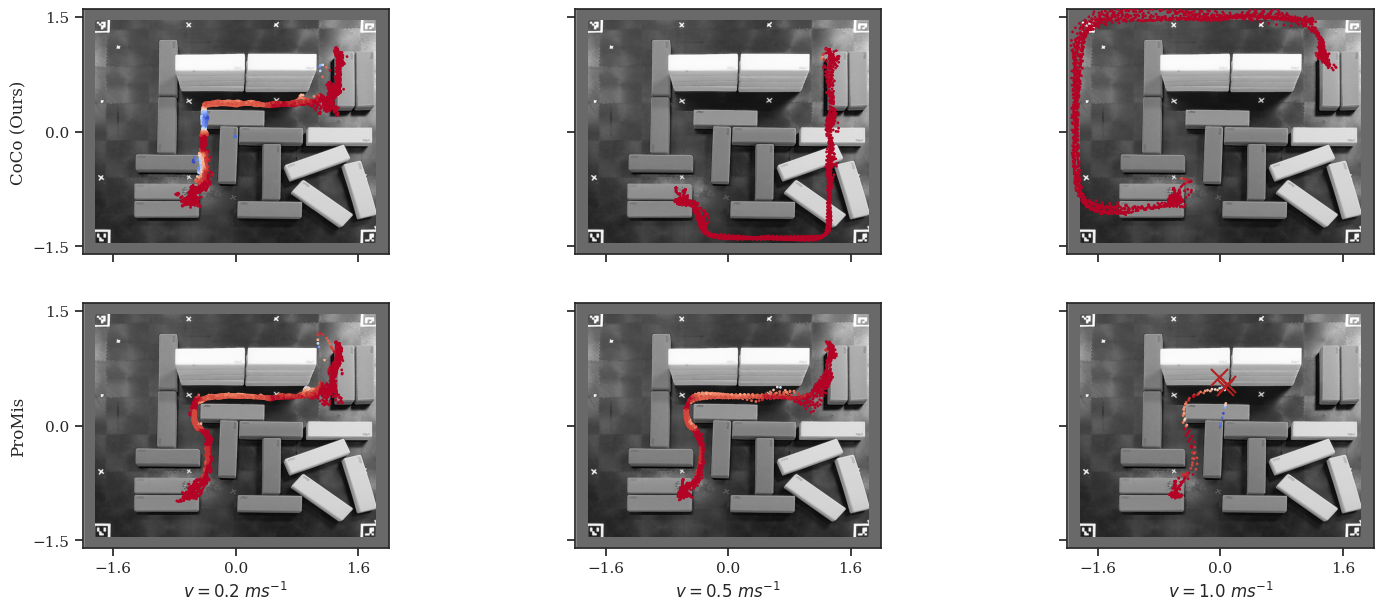

In [ ]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from promis import ConstitutionalController
from promis.geo import CartesianCollection

fig, axes = plt.subplots(2, 3, figsize=(18, 7), sharex=True, sharey=True)

paths = [
    ["rosbag-recordings/coco-fixed-0.2/*.csv", "rosbag-recordings/coco-fixed-0.5/*.csv", "rosbag-recordings/coco-fixed-1.0/*.csv"],
    ["rosbag-recordings/promis-0.2/*.csv", "rosbag-recordings/promis-0.5/*.csv", "rosbag-recordings/promis-1.0/*.csv"],
]

axes[0,0].set_ylabel("CoCo (Ours)")
axes[1,0].set_ylabel("ProMis")
axes[1,0].set_xlabel(r"$v = 0.2\ ms^{-1}$")
axes[1,1].set_xlabel(r"$v = 0.5\ ms^{-1}$")
axes[1,2].set_xlabel(r"$v = 1.0\ ms^{-1}$")

for speed_index in range(3):
    for setting in range(2):
        ax = axes[setting, speed_index]
        path = paths[setting][speed_index]

        ax.add_patch(
            plt.Rectangle((-2.0, -1.6), 4.0, 4.0, fc="dimgray", zorder=1)
        )
        ax.imshow(
            scene_image.convert("L"),
            cmap='gray',
            extent=(-1.835, 1.835, -1.45, 1.45),
            rasterized=True,
            zorder=2
        )

        ax.set_xlim(-2, 2)
        ax.set_ylim(-1.6, 1.6)
        ax.set_xticks([-1.6, 0.0, 1.6])
        ax.set_yticks([-1.5, 0.0, 1.5])

        if speed_index == 2:
            landscape = CartesianCollection.load("virtual_setup_landscape_speed_1.0.pkl")
        else:
            landscape = CartesianCollection.load("virtual_setup_landscape_speed_0.5.pkl")

        class Mock:

            def __init__(self):
                self.density = multivariate_normal([0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]])

            def sample(self, n, c):
                return [self.density.rvs(n)]

        matching_files = glob.glob(path)
        for file in matching_files:
            df = pd.read_csv(file)
            first_index = (df['stateEstimateZ'] < 0.2).idxmax() if (df['stateEstimateZ'] < 0.2).any() else None
            
            path = 1000.0 * np.vstack([df['stateEstimateX'], df['stateEstimateY']]).T
            compliance_ps = ConstitutionalController().compliance(path, landscape, Mock(), None, 100)

            if first_index is not None and first_index > 10 and setting == 1:
                ax.scatter(df['stateEstimateX'][first_index], df['stateEstimateY'][first_index], marker='x', c='firebrick', s=150, zorder=4)
                image = ax.scatter(df['stateEstimateX'].iloc[:first_index], df['stateEstimateY'].iloc[:first_index], c=compliance_ps[:first_index], s=1, cmap="coolwarm",  vmin=0, vmax=1.0, zorder=3)
            else:
                image = ax.scatter(df['stateEstimateX'], df['stateEstimateY'], c=compliance_ps, s=1, cmap="coolwarm", vmin=0, vmax=1.0, zorder=3)

cbar_ax = fig.add_axes([0.85, 0.1, 0.015, 0.85])
fig.colorbar(image, cax=cbar_ax, aspect=25, fraction=0.03, pad=0.02)

sns.despine()
fig.subplots_adjust(right=2.1, wspace=0.5)
plt.tight_layout()
plt.savefig("velocity_fixed_compliance.pdf")
plt.show()

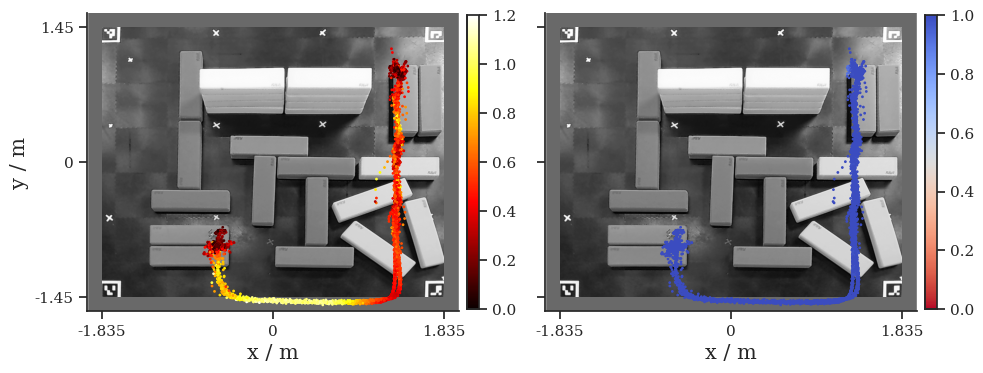

In [ ]:
import glob
import pandas as pd
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

for ax in axes:
    ax.add_patch(
        plt.Rectangle((-2.0, -1.6), 4.0, 4.0, fc="dimgray", zorder=1)
    )

    ax.imshow(
        scene_image.convert("L"),
        cmap="gray",
        extent=(-1.835, 1.835, -1.45, 1.45),
        rasterized=True,
        zorder=2
    )

    ax.set_xlim(-2, 2)
    ax.set_ylim(-1.6, 1.6)
    ax.set_xticks([-1.835, 0.0, 1.835], labels=["-1.835", "0", "1.835"])
    ax.set_yticks([-1.45, 0.0, 1.45], labels=["-1.45", "0", "1.45"])
    ax.set_xlabel("x / m", fontsize=15)
axes[0].set_ylabel("y / m", fontsize=15)

matching_files = glob.glob("rosbag-recordings/coco-dynamic/*.csv")
for file in matching_files:
    df = pd.read_csv(file)

    landscape = CartesianCollection.load("virtual_setup_landscape_speed_0.5.pkl")

    class Mock:

        def __init__(self):
            self.density = multivariate_normal([0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]])

        def sample(self, n, c):
            return [self.density.rvs(n)]
        
    path = 1000.0 * np.vstack([df['stateEstimateX'], df['stateEstimateY']]).T
    compliance_ps = ConstitutionalController().compliance(path, landscape, Mock(), None, 100)
    
    velocity_image = axes[0].scatter(df['stateEstimateX'], df['stateEstimateY'], c=df['velocity'], cmap="hot", s=1, zorder=3, vmin=0, vmax=1.2)
    compliance_image = axes[1].scatter(df['stateEstimateX'], df['stateEstimateY'], c=compliance_ps, cmap="coolwarm_r", s=1, zorder=3, vmin=0, vmax=1)

cbar = plt.colorbar(velocity_image, ax=axes[0], aspect=25, fraction=0.03, pad=0.02)
cbar = plt.colorbar(compliance_image, ax=axes[1], aspect=25, fraction=0.03, pad=0.02)

sns.despine()
plt.tight_layout()
plt.savefig('dynamic_coco.pdf')
plt.show()

Learning Doubt Density: 100%|██████████| 4/4 [00:01<00:00,  2.04epoch/s]


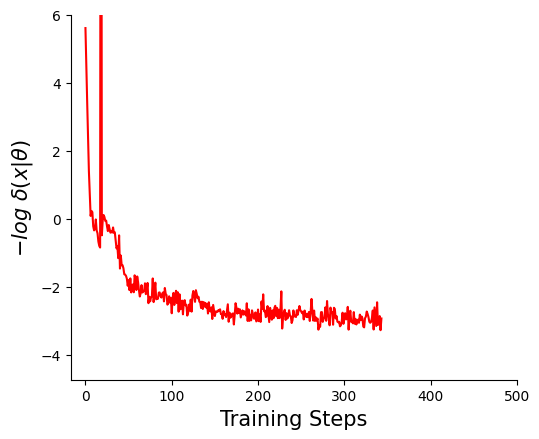

In [1]:
import glob
import torch
import pandas as pd
import numpy as np
from promis import DoubtDensity
import matplotlib.pyplot as plt
import seaborn as sns

torch.set_default_dtype(torch.double)

# Data preparation
training_xy = None
training_controller = None
training_speed = None
training_angle = None

for drone_speed in [0.2, 0.5, 1.0]:
    matching_files = glob.glob(f"rosbag-recordings/coco-fixed-{drone_speed}/*.csv")
    dfs = []
    for match in matching_files:
        dfs.append(pd.read_csv(match))

    for df in dfs:
        xs = torch.from_numpy(df["errorX"].to_numpy())[:, None]
        ys = torch.from_numpy(df["errorY"].to_numpy())[:, None]
        xy = torch.hstack([xs, ys])

        positions = torch.cat([torch.from_numpy(df["posCtltargetX"].to_numpy())[:, None], torch.from_numpy(df["posCtltargetY"].to_numpy())[:, None]], dim=1)
        directions = positions[1:] - positions[:-1]
        angles = torch.atan2(directions[:, 1], directions[:, 0])

        if training_xy is None:
            training_xy = xy[1:]
            training_speed = torch.from_numpy(df["velocity"].to_numpy())[1:, None]
            training_angle = angles[:, None]
        else:
            training_xy = torch.vstack([training_xy, xy[1:]])
            training_speed = torch.vstack([training_speed, torch.from_numpy(df["velocity"].to_numpy())[1:, None]])
            training_angle = torch.vstack([training_angle, angles[:, None]])

        # # Add randomly rotated copies
        # for _ in range(10):
        #     theta = torch.rand(1).item() * 2 * np.pi  # angle between 0 and 2π

        #     rotation_matrix = torch.tensor(
        #         [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
        #     )

        #     training_xy = torch.vstack([training_xy, xy @ rotation_matrix.T])
        #     training_speed = torch.vstack([training_speed, torch.from_numpy(df["velocity"].to_numpy())[:, None]])

# Training
doubt_space = {
    "speed": {
        "type": "continuous",
        "values": training_speed,
    },
    "yaw": {
        "type": "continuous",
        "values": training_angle,
    },
    "controller": {
        "type": "categorical",
        "number_of_classes": 3,
        "values": torch.tensor([0]).repeat((len(training_speed), 1))
    }
}

doubt_density = DoubtDensity(
    doubt_space=doubt_space, number_of_states=2, number_of_hidden_features=100, number_of_layers=5
)

number_of_epochs = 4
batch_size = 100
losses = doubt_density.fit(training_xy, doubt_space, number_of_epochs, batch_size)

# Show Loss
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
ax.plot(range(len(losses)), losses, c='r')
ax.set_xlim(None, 500)
ax.set_ylim(None, 6)
ax.set_ylabel(r"$-log\ \delta(x | \theta)$", fontsize=15)
ax.set_xlabel("Training Steps", fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig('doubt_loss.pdf', bbox_inches=0)
plt.show()

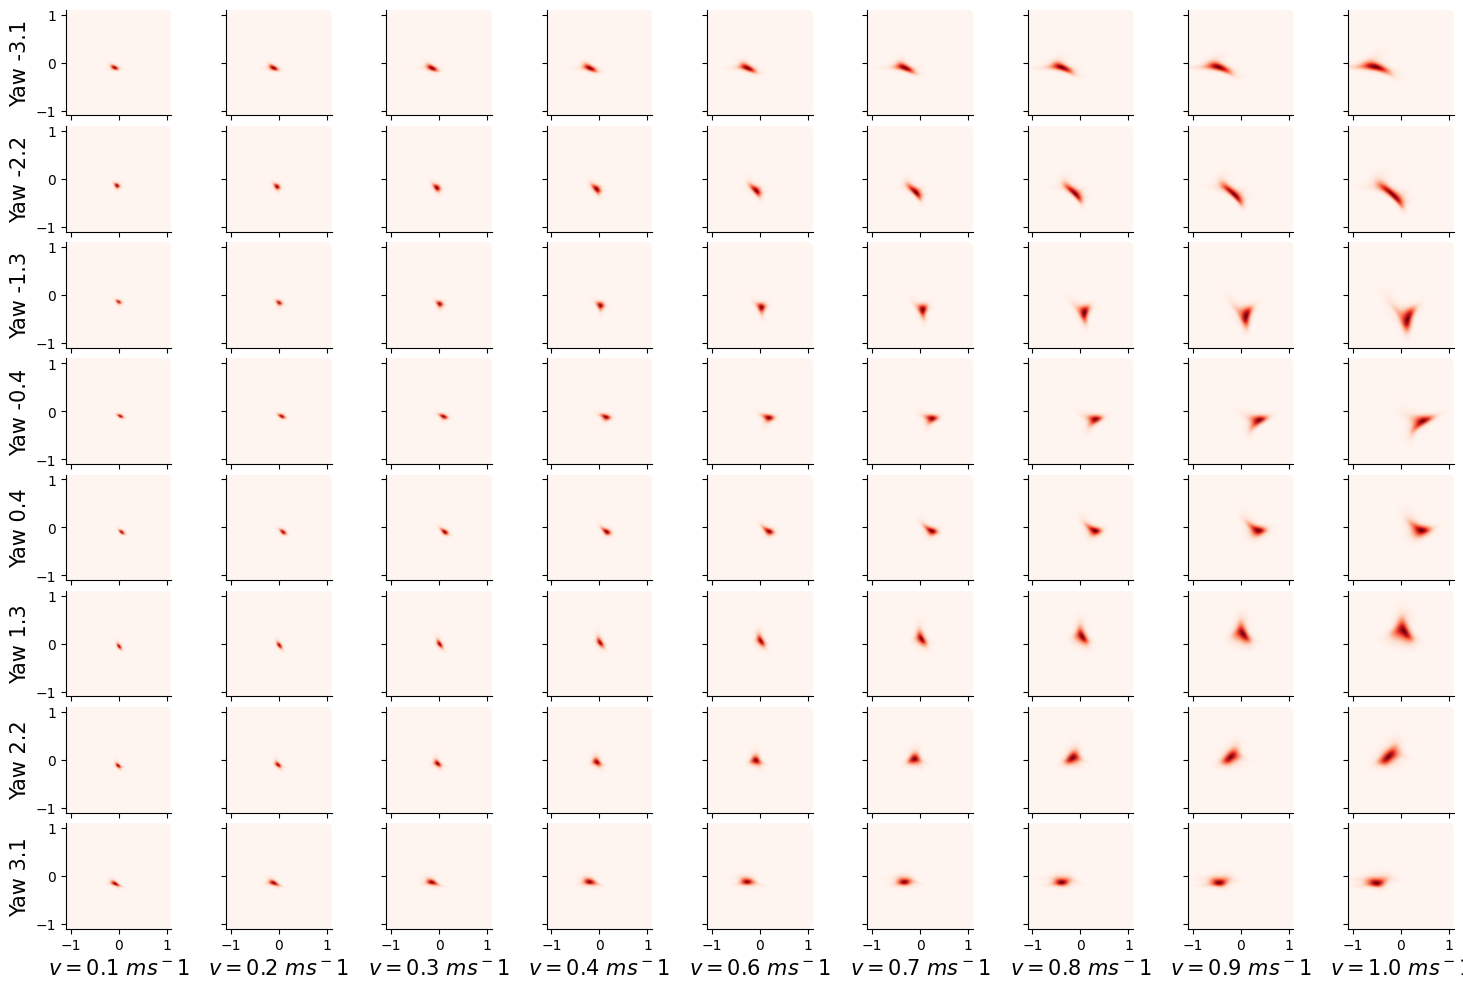

In [2]:
# Density
fig, ax = plt.subplots(8, 9, figsize=(15, 10), sharex=True, sharey=True)
speeds = np.linspace(0.1, 1.0, 9)
yaws = np.linspace(-np.pi, np.pi, 8)
for time_index, speed in enumerate(speeds):
    ax[7, time_index].set_xlabel(rf"$v = {speed:.1f}\ ms^{-1}$", fontsize=15)

for yaw_index, yaw in enumerate(yaws):
    for time_index, speed in enumerate(speeds):
        axis = ax[yaw_index, time_index]
        axis.set_aspect(1)
        axis.set_yticks([-1, 0, 1])
        axis.set_xticks([-1, 0, 1])

        if time_index == 0:
            axis.set_ylabel(f"Yaw {yaw:.1f}", fontsize=15)

        resolution = 100
        xline = torch.linspace(-1.0, 1.0, resolution)
        yline = torch.linspace(-1.0, 1.0, resolution)
        xgrid, ygrid = torch.meshgrid(xline, yline, indexing="xy")
        states = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            doubt_space["speed"]["values"] = torch.tensor([speed] * resolution * resolution)[:, None]
            doubt_space["yaw"]["values"] = torch.tensor([yaw] * resolution * resolution)[:, None]
            doubt_space["controller"]["values"] = torch.tensor([0] * resolution * resolution)[:, None]
            density = doubt_density.prob(states, doubt_space).reshape(resolution, resolution)
            # samples = doubt_density.sample(1000, doubt_space)

        # axis.scatter(samples[:, 0], samples[:, 1])
        axis.scatter(xgrid.numpy(), ygrid.numpy(), c=density.numpy(), cmap="Reds", rasterized=True)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(
    wspace=0.1,
    hspace=0.1,
)
plt.savefig("doubt_density.pdf")
plt.show()